# An introduction to machine learning using Python

This couse is desiged to give a gentle but practical introduction to the basic concepts encountered in machine learning. There will be very little maths involved and the Python programming used to run through the course will be fairly straightforward. This will hopefully be sufficient to demonstrate the key, high-level concepts behind machine learning and introduce a basic operational workflow. The objective is to empower the programmer to experiment with their own projects. Learning about the more mathematical inner workings of the machine learning approaches may well be of interest to those who wish to delve further. However, in many cases, this is not necessary to get a degree of intuition about the process, and to generate practical learning models.

The examples in this course will mostly be examples of *supervised* learning; machine learning models where the objective relates to some known, target data that is distinct from the input data to learn from. An example here would be to learn the classification of an image; the target classification (the label) is a somewhat separate quality from the input, although hopefully derivable from it. Where there is no separate set of target data, machine learning can be decribed as *unsupervised* and in these cases the objective is to learn to structure, or transform, the data to reveal its underlying organisation. It is notable that supervised and unsupervised aspects are mixed together in some cases, and so the supervised/unsupervised disctinction is more of a guide than a rule.

An often mentioned aspect of machine learning, which will not be covered here, is *reinforcement* learning. This is 
is like unsupervised learning, in that it has no separately supplied target data/labels. However, the learning objective responds to a reward from an external environment. An example would be a car learning to drive within the street envrionment indicated by its sensors, rewarded by following the rules of the road and not crashing.

## Python modules for machine learning

As we move through machine learning concepts here we will make extensive use of the SciKit learn Python library. This is an excellent collection of almost everything we will need to get started. It should be noted that we will initially only cover the more traditional, non-deep leaning methods; deep neural networks are covered in the next course.

For this course, a basic familiarity with the Python language and its NumPy module is assumed. The Python Beginners' Course and Numeric Python Course are provided separately, if needed. 

Our first Python code is to import the handy modules that we will be using throughout: Numpy, aliased as `np` is for the array/tensor based operations, `sklearn` provides the specialised machine learning functions and pyplot, asliased as `plt` allows us to visualise the data in a graphical way.

In [285]:
# Main module imports for the course
import numpy as np
import sklearn
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

As the purpose of this course is to teach machine learning, and not the finer points of the Python language, alongside this notebook we include a helper module `course_util.py`, that will allow the code examples to be simplified. Mainly this module contains functions for data loading and to plot data ini particular ways.

In [286]:
# Import a helper module that goes with this course
import course_util as util
import importlib
importlib.reload(util)

<module 'course_util' from '/home/tjs23/gh/python_ml_course/course_util.py'>

## Separating data clusters

For our first example we will consider some synthetic data. The data is two-dimensional and can be thought of as a seris of (x,y) points. This is perhaps trivial and dull data, but we can control how it is generated and it will allow us get to the core of various machine learning aspects.

The synthetic data will be constructed by making three groups of normally distributed (Gaussian) data. Each group's statistical distribution has different parameters: an `[x,y]` centre; mean, and a spread; circular standard deviation. The three data groups are made of 50, 100, and 200 points respectively, sampled randomly from the three distributions.

In [ ]:
# Normally distributed random numbers
group1 = np.random.normal([-0.2, 0.0], 0.3, (50,2))  # Input [means], std dev, array size
group2 = np.random.normal([0.8, 0.8], 0.2, (100,2))
group3 = np.random.normal([0.0, 1.0], 0.5, (200,2))

To go along with these data we construct arrays indicating the original, true group identities of all these points. This will be done using integer values `0`, `1` and `2` to indicate the group label. These labels will then serve as the idealised targets for machine laerning models to recreate.

In [298]:
labels1 = np.full(50 , 0)  # 50 of class 0
labels2 = np.full(100, 1)  # 100 of class 1
labels3 = np.full(200, 2)  # 200 of class 2
print(labels1[:10])
print(labels2[:10])
print(labels3[:10])

[0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1]
[2 2 2 2 2 2 2 2 2 2]


The three data groups and their labels are then joined into one 2D array, via `concatenate`.

In [320]:
# Combine groups and index labels into single array
mixed_data = np.concatenate([group1, group2, group3])
true_classes = np.concatenate([labels1, labels2, labels3])

The final preparation step is to shuffle the data, so that the order of the data containes no information.

In [321]:
idx = np.arange(len(true_classes)) # Natural index order 0 .. n
order = np.random.permutation(idx) # Random shuffle indices

mixed_data   = mixed_data[order]       # Reorder arrays
true_classes = true_classes[order]
print(order[:10])

[169 136 280  84 168 343  53 125  33 247]


We can extract the X- and Y- coordnates of our array to plot the overall data. Note that we transpose the array with `.T`; this swaps the rows with the columns, and provides a handy means of assiging to separate X and Y coordinates, which are required for the scatter plot. (We could also use `mixed_data[:,0]` to get all rows, X column etc.).

(350, 2)
(2, 350)


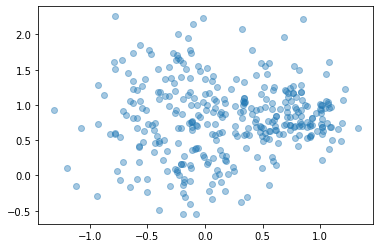

In [325]:
print(mixed_data.shape)
print(mixed_data.T.shape)
xx, yy = mixed_data.T

# Make scatterplot with X and Y points
plt.scatter(xx, yy, alpha=0.4) # alpha sets opacity to show overlap better
plt.show()

Plotting the label value for each position in `true_classes` shows items are randomly allocated to `0`, `1`, or `2`

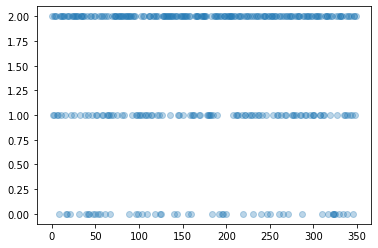

In [328]:
# Concatenate lists of 0, 1 and 2 and convert to array
plt.scatter(idx, true_classes, alpha=0.3)
plt.show()

To visualise the true/target group labels we can plot the original groups separately in different colours. Note that there is some overlap between the classes and so we would not expect to be able to separate these perfectly based on [x,y] location. Note the use of `*` here which is a handy way of in unpacking the X and Y coordinates for the plotting function. Also the `c=` oprtion passed to the sccatter plot is simply an array of index labels, and the colour map `cmap` converts each index into a different colour on the scale.

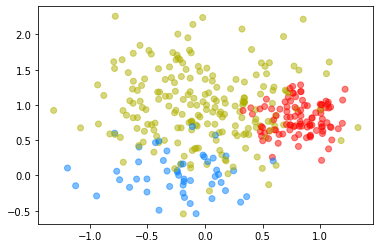

In [329]:
cmap1 = util.colorlist('#0080FF','#FF0000','#B0B000')
plt.scatter(*mixed_data.T, c=true_classes, alpha=0.5, cmap=cmap1)

The first learning approach use here, to separate and classify the mixed data, is via **k-means clustering**. This simple clustering will be used to separate the data, and then using the learned separation rules (the boundaries) we can make predictive classifications, on data not used in the initial clustering.

As is typical with `sklearn`, we employ one of its modules to create a *model*. Here the model simply refers to a parameterised object with methods for discriminating or transforming data, that can learn by adaptation to a training dataset. Here the adaptation is done by invoking `.fit()` on the mixed group data. The value of `3` passed to the `KMeans` model states that three clusters are to be fit, and setting the `random_state` provides reproducibility.

In [333]:
kmeans_model = sklearn.cluster.KMeans(3, random_state=3)
kmeans_model.fit(mixed_data)

KMeans(n_clusters=3, random_state=3)

Once the data is fit to the model we can inspect its attributes to see the results. Here we look at `.labels_`, which is an integer array of classifiations, indicating which cluster, of the three possibilities, each point belongs to.

In [334]:
k_classes = kmeans_model.labels_
print(k_classes[:20]) # Some cluster allocations

[2 1 2 1 0 0 1 1 0 1 1 2 2 2 2 1 0 2 0 2]


The class labels `k_classes` can then be used to colour the mixed data. Note how linear boundaries are used to separate three clusters. The boundaries arise because k-means clustering defines cluster centres and then allocates points to their closest centre.

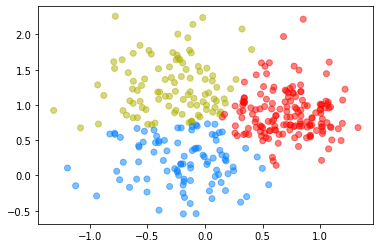

In [338]:
plt.scatter(*mixed_data.T, c=k_classes, alpha=0.5, cmap=cmap1)
plt.show()

Next, three new, points `pred_points` are defined, which we can superimpose upon the clusters, here as black spots.

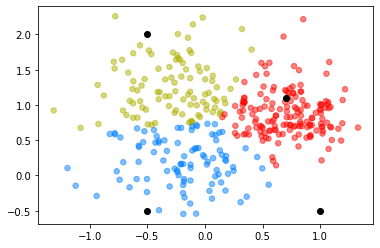

In [339]:
pred_points = np.array([[-0.5, -0.5],
                        [ 0.7,  1.1],   
                        [-0.5,  2.0],
                        [ 1.0, -0.5]])

plt.scatter(*mixed_data.T, c=k_classes, s=30, alpha=0.5, cmap=cmap1)
plt.scatter(*pred_points.T, color='k')
plt.show()

To obtain the classification for the new points the `.predict()` method is run, from the previously fitted model, using these points. In essence, the model is determining which region each of the new [x,y] coordinates lies within. Note that, although the clusters separated here mostly match the original groups, the actual index numbers used to label each class are somewhat arbitrary and are often swapped round.

In [340]:
print(kmeans_model.predict(pred_points))

[0 1 2 0]


To get a clearer indication of the decsion boundaries used for this classification we can run the model prediction on a wide sample of points to observe the outcome.

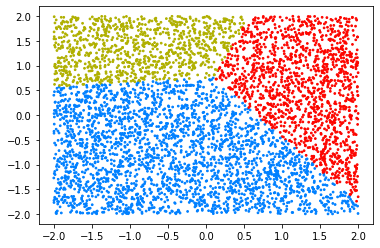

In [344]:
sample_data = np.random.uniform(-2.0, 2.0, (5000, 2)) # 5000 two-dimensional points
sample_classes = kmeans_model.predict(sample_data)

plt.scatter(*sample_data.T, c=sample_classes, s=3, cmap=cmap1)
plt.show()

The `sklearn` module has a handy `DecisionBoundaryDisplay` object to perform the same task, by selecting from a grid.

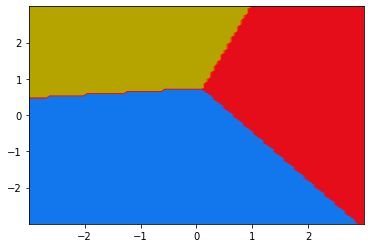

In [343]:
from sklearn.inspection import DecisionBoundaryDisplay
disp = DecisionBoundaryDisplay.from_estimator(kmeans_model, sample_data, cmap=cmap1, response_method="predict")

The next ML method illustrated moves beyond simple clustering to a more canonical machine learning method: **k-nearest neighbours** (k-NN). With the clustering we let the model separate into a given number of classes. However, for k-NN (like many ML methods) we will specify input training data with directly paired target labels. Accordingly, each input [x,y] point (`mixed_data`) is directly tied a corresonding class integer (0, 1 or 2) during fitting, indicating its true identity (`true_classes`).

The k-NN model is created and then fitted to the data in the manner typical of `sklearn`. Here the `KNeighboursClassifier` has the number of neighbours parameter set to `5`, but you may like to see the effect of choosing other values. 

In [345]:
knn_model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)
knn_model.fit(mixed_data, true_classes)
knn_classes = knn_model.predict(mixed_data)

Internally the k-NN method makes predictions on unseen datapoints by taking a poll of its *k* nearest neighbours (*k*=5 here) with a class label. The majoriy class label from the training neigbours is then taken as the prediction for the unseen point. As is illustrated in the below plots, the k-NN often has curved decision boundaries, which can more or less closely hug the training labels, according to the value of *k*; smoother for larger values.

Text(0.5, 1.0, 'True Class')

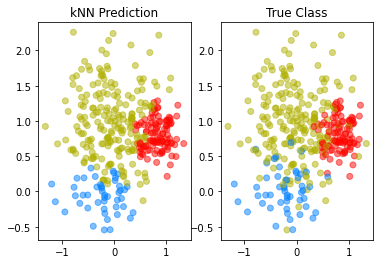

In [346]:
fig, (ax1, ax2) = plt.subplots(1, 2) # Subplots in one row, two columns

ax1.scatter(*mixed_data.T, c=knn_classes, alpha=0.5, cmap=cmap1)
ax1.set_title('kNN Prediction')

ax2.scatter(*mixed_data.T, c=true_classes, alpha=0.5, cmap=cmap1)
ax2.set_title('True Class')

For contrast we will show another, commonly used, type of machine leaning model. This is a kind of Support Vector Machine (SVM); we will skip detailed discussion of the inner workings of this method, but suffice it to mention that SVMs are able to separate data by applying a *kernel function* to the data to spread the data into extra dimensions (new axes) according to their training label. Here you can imagine that each of the training [x,y] points is given an extra "z" coordinate so that the three classes are separated into different layers. The decision boundaries between label classes will be flat planes though this higher dimensional space, though these often appear as curves when projected down into the original 2D space.

The model is generated and fit from using the support vector classifier method (`SVC()`), which is a subtype of SVM.

In [347]:
svm_model = sklearn.svm.SVC()
svm_model.fit(mixed_data, true_classes)
svm_classes = svm_model.predict(mixed_data)

Plotting the predictions for this method, albeit for the training data, shows that the separation is according to curved boundary, which fits the data resonably well.

Text(0.5, 1.0, 'True Class')

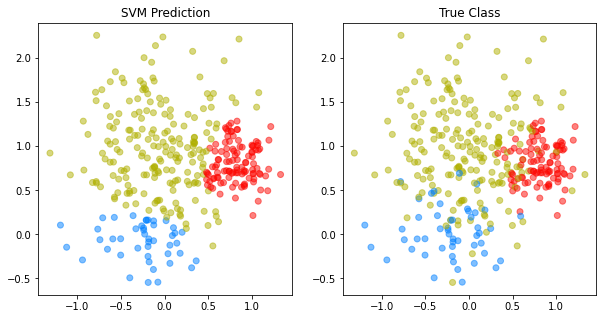

In [348]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
scatter_kw = dict(alpha=0.5, cmap=cmap1)

ax1.scatter(*mixed_data.T, c=svm_classes, **scatter_kw)
ax1.set_title('SVM Prediction')

ax2.scatter(*mixed_data.T, c=true_classes, **scatter_kw)
ax2.set_title('True Class')

##  <font color="purple">Exercise:</font>

<font color="purple">As the demo data is really generated by a mixture of Gussians, in reality the most appropriate ML method to apply would be the Gaussian Mixture Model. This aims to recapitulate the means and standard distributions of an number of underlying distributions. Also, this method is useful in that we can quantify the degree of class overlap, betweeen two or mode deconvolved Gaussians, for any point.

As an exercise fit a `class sklearn.mixture.GaussianMixture` model for the data, in a similar manner to other approaches. Then run `.predict()` and plot the output as a scatter, similar to above.

</font>

In [349]:
gmm_model = sklearn.mixture.GaussianMixture(n_components=3)  # Model as 3 normal distribs

# Exercise code goes here
"""
gmm_classes = ...


fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

ax1.scatter(group_x, group_y, c=gmm_classes, **scatter_kw)
ax1.set_title('GMM Prediction')

ax2.scatter(group_x, group_y, c=true_classes, **scatter_kw)
ax2.set_title('True Class')"""

"\ngmm_classes = ...\n\n\nfig, (ax1, ax2) = plt.subplots(1, 2)\nfig.set_size_inches(10, 5)\n\nax1.scatter(group_x, group_y, c=gmm_classes, **scatter_kw)\nax1.set_title('GMM Prediction')\n\nax2.scatter(group_x, group_y, c=true_classes, **scatter_kw)\nax2.set_title('True Class')"

Using the random sampling approach, as before, we can explore the 2D decision boundaries for each of the ML methods used so far. Note how the different methods have different shaped boundaries and that this will have an impact on how the classifier extrapolates to values distant from the training data.

In [350]:
sample_data = np.random.uniform(-3.0, 3.0, (5000, 2)) # 5000 times [x,y] pointsm, sampled uniformly from -2 to 2 
pred1 = kmeans_model.predict(sample_data)
pred2 = knn_model.predict(sample_data)
pred3 = svm_model.predict(sample_data)

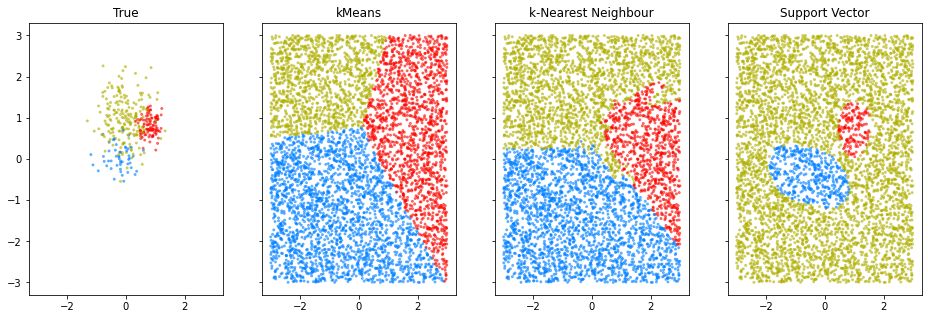

In [353]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, sharex=True, sharey=True)
fig.set_size_inches(16,5)
plot_params = dict(s=4, alpha=0.5, cmap=cmap1)

ax0.scatter(*mixed_data.T, c=true_classes, **plot_params)
ax0.set_title('True')

ax1.scatter(*sample_data.T, c=pred1, **plot_params)
ax1.set_title('kMeans')

ax2.scatter(*sample_data.T, c=pred2, **plot_params)
ax2.set_title('k-Nearest Neighbour')

ax3.scatter(*sample_data.T, c=pred3, **plot_params)
ax3.set_title('Support Vector')
plt.show()

It is clear that these predictors operate fairly differently outside of the data-rich region. In a real-world sitruation the best method will depend on the task at hand. When dealing with somewhat different, outlier points, a linear extrapolation may be resonable but in other cases having one class become the default (as happens here with SVM) may be better. 

In some situations it may be better to make no classification at all if a data point occurs well outside the trained region. One approach would be to pre-check data and exclude based on (dis)similarity to known data. A means of doing this automatically inside the same machine learning model is to add a new *null* class outside the region of labelled data. 

Below is some code to generate data points randomly from a region [-3.0, 3.0], on both axes, and keep only those points that are more than a certain distance away from all known points. These points and their new class label can then be added to the previous mixed dataset.

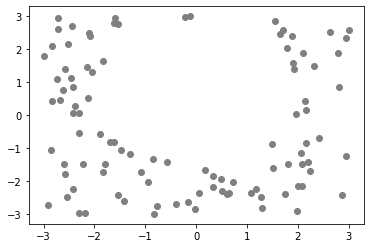

In [355]:
# Create random data for a new, null, class
# points should not be too close to existing examples
null_data = []
null_labels = []

while len(null_data) < 100:
    point = np.random.uniform(-3.0, 3.0, 2)      # Random 2D point
    diffs = mixed_data - point                   # Difference to all known data
    min_dist2 = min((diffs * diffs).sum(axis=1)) # Smallest square distance
    
    if min_dist2 < 0.5:  # Skip if too close
        continue
    
    # When not too close add a null point and its class index 
    null_data.append(point)
    null_labels.append(3)
    
null_data = np.array(null_data)
null_labels = np.array(null_labels)

plt.scatter(*null_data.T, color='#808080')
plt.show()

The new, random null class data and labels are added to the end of the previous dat via `np.concatenate`.

In [359]:
# Extend original training data, and target labels, with null data
ext_data = np.concatenate([mixed_data, null_data])
ext_classes = np.concatenate([true_classes, null_labels])

The same kinds of machine learning model can then be fit to this extended data in the usual manner. Note thate we are initialising the k-means clustering with `pred_points` so that its class indices will match what we had previously; else the cluster numbers will be arbitrary.

In [360]:
kmeans_model2 = sklearn.cluster.KMeans(4, init=pred_points)
kmeans_model2.fit(ext_data)

knn_model2 = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)
knn_model2.fit(ext_data, ext_classes)

svm_model2 = sklearn.svm.SVC()
svm_model2.fit(ext_data, ext_classes)

SVC()

The trained models are then used for making predictions on the same randomly sampled data as before, to show the decsion boundaries.

In [361]:
pred1 = kmeans_model2.predict(sample_data)
pred2 = knn_model2.predict(sample_data)
pred3 = svm_model2.predict(sample_data)

We create new colour map with an extra grey to represent the new null class, and plot the preedictions as before.

It is clear that the k-Means clustering doesn't cope with the data being surrounded by a sea of null class points. However, for k-NN and the SVM the null class has prevented any predictions to the original classes where the data is sufficiently distant from the known data.

Text(0.5, 1.0, 'Support Vector')

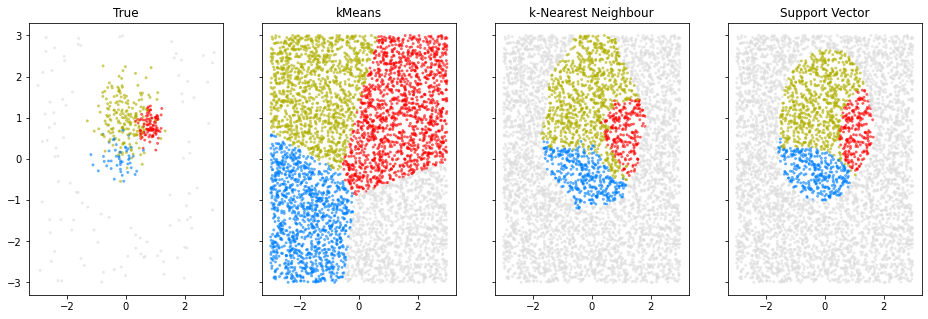

In [362]:
cmap2 = util.colorlist('#0080FF','#FF0000','#B0B000','#DDDDDD') # Colormap now has grey

fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, sharex=True, sharey=True)
fig.set_size_inches(16,5)
plot_params = dict(s=4, alpha=0.5, cmap=cmap2)

ax0.scatter(*ext_data.T, c=ext_classes, **plot_params)
ax0.set_title('True')

ax1.scatter(*sample_data.T, c=pred1, **plot_params)
ax1.set_title('kMeans')

ax2.scatter(*sample_data.T, c=pred2, **plot_params)
ax2.set_title('k-Nearest Neighbour')

ax3.scatter(*sample_data.T, c=pred3, **plot_params)
ax3.set_title('Support Vector')

## Overall ML workflow

<img src="workflow_diag_01.svg" style="width: 500px;" align="right"/>

The generalised machine learning workflow pictured here illustrates the flow of data and its prepatation prepared.

Initially a quantity of data is collected for the trainaing process. If this is not sufficient to create model with acceptable performance more data may need to be aquired.

The collected data is generally separated into data which forms model **input** and data that acts as a **target**, to which model output is compared. 

After this separation and any general reformatting or encoding (e.g. classes as numerical values) the data is split into separate **testing** and **training** segments, and also (as data alows) a **validation** set, which is only used at the end.

Numeric data is sometimes intially not in the useful value range for the ML models (typically within -1 to +1) or it may have an unhelpful distribution, and so datasets are scaled and normalised. For example, data may be converted to log-space to reduce dynamic range and/or scaled so that it is centred on zero with a standard deviation of 1.0.

Typically data is scaled, or normalized, according to parameters (mean, standard deviation etc.) extracted from **only the training** set, but then also applied in the same way to the **testing and validation** sets. This is so that data not seen by the model cannot influence the pre-processing, but the same pre-processing is used throughout.

Internal model parameters are refined by fitting the ML model to the pre-processed **training** datset. Once fit, the model may then be evaulated by making predictions on the **test** set (not used in fitting) and comparing the model output with ideal target values. 

The model may then be further refined with more training, and/or by optimisation of its hyperparameters. Hyperparameters refer to those settings for a model that control behaviour but which are not optimised during fitting, e.g. how to weight classes, how many neightbours to use in k-NN, which kernel to use for SVM, how many neural network layers to use etc... The choice of which kind of ML model to use, e.g. Random Forest, SVM or k-NN, can be considered part of this optimisation.

With the trained, best model (or models, given several test-train splits) selected, the model is fixed and can be evaluated on a validation data set, which is completely new to the model. Should the model be sufficiently performant, it may then be deployed to run inference (e.g. make predictions) on new input data in a production context.

## Test train split

To objectively assess a machine learning model we need to have a set of data for testing that was not used during training. It is often trivial to create boundaries around all known examples, appearing to make a perfect classifier, when in reality it has effectively memorised the input and doesn't generalise well.

Hence, when developing a particular machine learning model for a given task we almost always separate our total available data into separate *test* and *training* sets. The training data will be used to refine details of the model's parameters because it is used in fitting, while the test data is only used to assess how well the model performs. Typically 10-30% of the data is reserved for testing and it is usually selected randomly. Often we will do serveral, completely separate model fitting attempts with different random allocations of test:train, so that we can assess how the random selection affects our model's performance, e.g. using *k-fold cross validation*, as we illustrate below. 

In some cases, depending on the situation and data availability, there may also be a special, separate *validation* set that is completely separate from both the test and trainaing sets. The notion here is that while the test test is not used to directly fit the model it is generally used to decide the best high-level parameters (*hyperparameters*); an example here would be deciding on the *k* value in a k-NN classifier. Hence, the test data did have some influence on the model formulation. The validataion set, being entirely separate, is only used to demonstrate performance once model paramaters and hyperparameters are fixed.

To split a dataset into test and train sections the handy `train_test_split` function from `sklearn` can be used. We simply supply an array of the possible input data, a corresponding array of the target data (i.e. with corresponding rows) and a test fraction of `0.2`. The result of this are fours arrays; the randomly allocated train and test sets for both the input and target labels (ideal outputs).

In [363]:
from sklearn.model_selection import train_test_split
in_train, in_test, target_train, target_test = train_test_split(ext_data, ext_classes, test_size=0.2)

We then fit an SVM model with only the *train* section that comes from the data split. Predictions are then run on the *test* data for assessment. Though, natutally, we are free to predict on any data. 

In [364]:
svm_model3 = sklearn.svm.SVC()
svm_model3.fit(in_train, target_train)
svm_pred3 = svm_model3.predict(in_test)

Plotting the predictions for the x,y points shows that they broadly match the training set classifications.

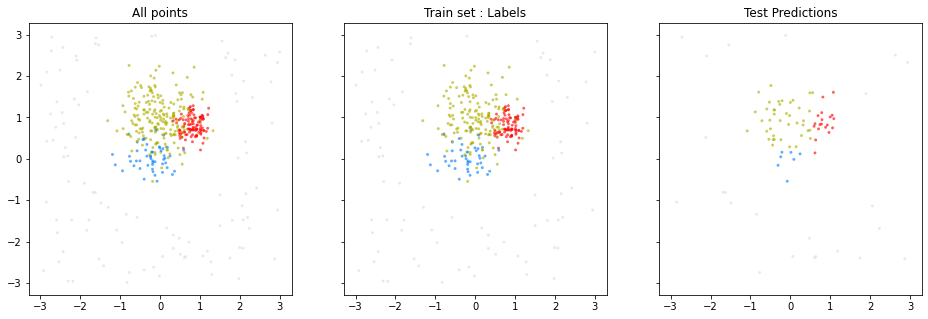

In [368]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True)
fig.set_size_inches(16,5)

ax1.scatter(*ext_data.T, c=ext_classes, **plot_params)
ax1.set_title('All points')

ax2.scatter(*in_train.T, c=target_train, **plot_params)
ax2.set_title('Train set : Labels')

ax3.scatter(*in_test.T, c=svm_pred3, **plot_params)
ax3.set_title('Test Predictions')
plt.show()

To assess how well the classifier performs we can calculate various metrics. We will cover many more metrics below, but for now we will calculate the **accuracy** of preditions of the test set. The accuracy is the fraction of the total predictions that are of the correct class. This is easy to calculate in `sklearn` using `accuracy_score`, to which we pass the ideal classifications and the predictions.

In [369]:
acc = sklearn.metrics.accuracy_score(target_test, svm_pred3)
print(f'Accuracy: {100.0*acc:.2f}%')

Accuracy: 87.78%


To provide more detail of how errors were made when prediction amoung the four classes (including our extra null) we can plot a matrix of the true class (label) verses the predicted class. This is known as a *confusion matrix* and is readily acieved via `sklearn`.

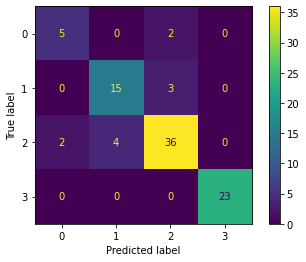

In [370]:
conf_mat = sklearn.metrics.confusion_matrix(target_test, svm_pred3)
disp = sklearn.metrics.ConfusionMatrixDisplay(conf_mat)
disp.plot()

## Cross-validation and ensembles

Moving on from a single, test-train split we can perform multiple different, random splits and then look at the variation in performance of differently trained models. This shows the variance within predictions and means we don't rely on a single test-train split, which could be unrepresentitive. 

The specific way we will achieve this is to use repeated *k-fold* splits, and `sklearn` provides a means to do this easily. Here we will split the data into five chunks, of approx equal, size and use **one** of those chunks as the test set and the remaining **four** as training. The test chunk will then cycle round so we get five different 20%-80% splits   where the test data does not overlap. And then the whole process is repeated with different random allocations, so that overall we get ten different splits. From these ten splits we will train and assess ten separate models.

The `RepeatedKFold` object is first created with its high level parameters; split into `5` chunks, and repeat `2` times. 

In [371]:
from sklearn.model_selection import RepeatedKFold

rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=7)
num_splits = rkf.get_n_splits(ext_data, ext_classes)

print(num_splits)
print(rkf)

10
RepeatedKFold(n_repeats=2, n_splits=5, random_state=7)



We can loop thrhough the train-test splits that are generated by `rkf.split` and for each we fit an SVM model to the train set, predict on the test set and measure the accuracy. Note how `rkf.split` provides array *indices*, rather than partial copies of the arrays. Hence, we use these indices to select sub-sets from the total data.  

In [372]:
n = len(ext_classes)
point_acc = np.zeros(n)

for i, (train_index, test_index) in enumerate(rkf.split(ext_data)):

    svm_model = sklearn.svm.SVC()
    svm_model.fit(ext_data[train_index], ext_classes[train_index])
    svm_pred = svm_model.predict(ext_data[test_index])
    
    test_targets = ext_classes[test_index]    
    acc = sklearn.metrics.accuracy_score(test_targets, svm_pred)    
    point_acc[test_index] += (test_targets == svm_pred).astype(int)
    
    print(f"Model:{i} Accuracy:{100.0*acc:.2f}%")
    
point_acc /= point_acc.max()

Model:0 Accuracy:85.56%
Model:1 Accuracy:86.67%
Model:2 Accuracy:88.89%
Model:3 Accuracy:87.78%
Model:4 Accuracy:88.89%
Model:5 Accuracy:85.56%
Model:6 Accuracy:91.11%
Model:7 Accuracy:91.11%
Model:8 Accuracy:82.22%
Model:9 Accuracy:90.00%


Here we are calculating an accuracy for each point by assessing whether its class was correctly predicted when it was used as test data. Naturally, we can get a better accuracy estimate by repeating the k-fold splits more times. Plotting the point accuracy shows that the prediction errors occur where we expect; where the classes overlap.

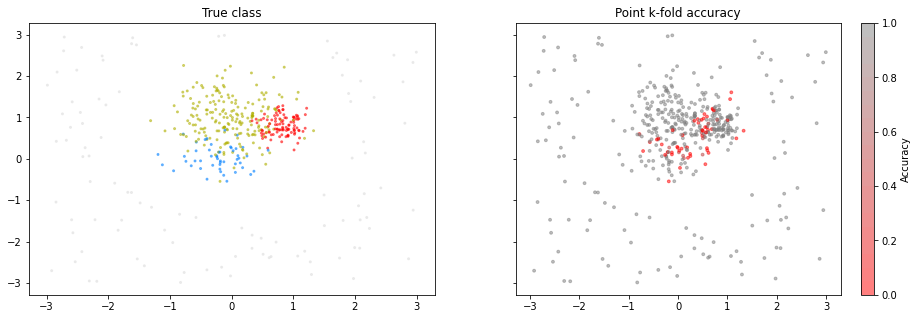

In [373]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(16,5)
cmap3 = util.colorlist('#FF0000','#808080')

ax1.scatter(*ext_data.T, c=ext_classes, **plot_params)
ax1.set_title('True class')

sc2 = ax2.scatter(*ext_data.T, c=point_acc, s=8, alpha=0.5, cmap=cmap3)
ax2.set_title('Point k-fold accuracy')

cb2 = fig.colorbar(sc2, ax=ax2)
cb2.set_label('Accuracy')

## Assessment metrics
  
So far we have looked at predictive accuracy and confusion matrices to assess the predictive abilities of our trained models. However, there are several other assement metrics that are commonly used, and which we will cover here

#### Precision

Precision is a measure of the **positive correctness proportion**. For a given class, it is the number of correct class predictions divided by the number of all predictions for the class. In terms of true postive (TP) and false positive (FP) predictions, where "postitive" means selecting for our class, it may be written as:

$TP / (TP + FP)$

#### Recall

Recall is a measure of the **positive detection proportion**. For a given class, it is the number of correct class predictions divided by the size of the class. In terms of true postive (TP) and false negative (FN) predictions, it may be written as:

$TP / (TP + FN)$ 


recall an precision are readily calculated with finctions from the `sklearn.metrics` module. We simply need to pass the ideal classes for the **test** set (`out_test`) and the corresponding ML model predictions. Note that because we have four class labals there will be for precision and recall metrics; comparing each class to the remainder.

In [396]:
pres = sklearn.metrics.precision_score(target_test, svm_pred3, average=None)
recs = sklearn.metrics.recall_score(target_test, svm_pred3, average=None)

for i in range(4):
    print(f'Class: {i} Recall:{recs[i]:.2f} Precision:{pres[i]:.2f}')

Class: 0 Recall:0.71 Precision:0.71
Class: 1 Recall:0.83 Precision:0.79
Class: 2 Recall:0.86 Precision:0.88
Class: 3 Recall:1.00 Precision:1.00


Rather than showing separate metrics for each class we can report overall 'macro' averages. See [this documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html] for different averaging methods. 

In [385]:
pre = sklearn.metrics.precision_score(target_test, svm_pred3, average='macro')
rec = sklearn.metrics.recall_score(target_test, svm_pred3, average='macro')

print(f'Macro averages - Recall:{rec:.2f} Precision:{pre:.2f}')

Macro averages - Recall:0.85 Precision:0.85


#### Accuracy

As we have seen above accuracy is the **overall correctness proportion**. It is equal to the number of correct predictions (any class) divided by the total number of predictions (N). In terms of true postive (TP), true negative (TN), false positive (FP) and false negative (FN) predictions for a class, it may be written as:

$(TP + TN) / (TP + TN * FP + FN) = (TP + TN) / N$

    
#### F1-score

The F1-score is a measure of positive predictive performance **combining precision and recall**. The notion here is to get a combined score to indicate when both precision and recall are good; separately precision can be high when recall is low, and vice versa. It is calculated as the harmonic average of precision and recall. 

$F1 = 2 (Precision . Recall) / (Precision + Recall)$

#### Cohen's Kappa

Cohen's Kappa is a means to measure how a classifier **disagrees with a random assignment**. For example if we have two, balanced classes then making 'predictions' completely at random will be correct around 50% of the time. Hence, only predictors that operate somewhat better than the random expectation have any merit.

In [390]:
acc = sklearn.metrics.accuracy_score(target_test, svm_pred3)
kap = sklearn.metrics.cohen_kappa_score(target_test, svm_pred3)
f1 = sklearn.metrics.f1_score(target_test, svm_pred3, average='macro')

print(f'Acc:{acc:.2f} Kappa:{kap:.2f} Macro F1-score:{f1:.2f}')

Acc:0.88 Kappa:0.82 Macro F1-score:0.85


Conveniently `sklearn` can provide a summary with several performance metrics via `classification_report()`, for both individual classes and overall (macro) averages. 

In [392]:
print(sklearn.metrics.classification_report(target_test, svm_pred3))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71         7
           1       0.79      0.83      0.81        18
           2       0.88      0.86      0.87        42
           3       1.00      1.00      1.00        23

    accuracy                           0.88        90
   macro avg       0.85      0.85      0.85        90
weighted avg       0.88      0.88      0.88        90



Lastly, we illustrate the precsion-recall (PR) relationship as a curve, for the SVM predictions of one class. The notion here is that rather than just quoting a single pair of precision and recall, a range of values can be obtained by changing a threshold used by the model to discern the agreement between ideal and predicted output. However, given the SVM model is classifier, which outputs a label index [0 .. 3], we must investigate the underlying scores from the model prediction, rather than the categorcal output; for the normal output categories match or not, and there is no gradation. To get the score output we use the models `decision_function()` method and then use the handy `precision_recall_curve()` (on the true classes and prediction scores) to obtain the precision and recall values to plot. Note that we specify `pos_label` to select which class is deemed to be 'positive' with regard to the metrics; 'negative' relates to prediction to some other class.

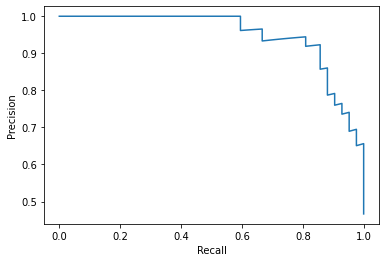

In [415]:
from sklearn.metrics import precision_recall_curve
pos_label = 2

# Get classifier scores
scores = svm_model3.decision_function(in_test)

# Make curve for ONE class
ideal_class = target_test == pos_label  # True at out selected label
score_class = scores[:,pos_label] # Scores for our selected label

precisions, recalls, thresholds = precision_recall_curve(ideal_class, score_class)

fig, ax = plt.subplots()
ax.plot(recalls, precisions)
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
plt.show()

## Data as a vector

So far we have illustrated some machine learning principles using simple synthetic data, i.e. each point corresponds to two values; (x,y). Real world examples will tend to have many more than two values for each data point, i.e. points will be N-dimensional vectors; they will have N separate features, where N is much larger than 2. 

As an example, below we use image data where each data point represents the intensity of 64 image pixels. Thus, the data array we use has one row for each image and 64 columns; each pixel is a separate feature.

Another example is for representing biological dequence data. In this case we have categorical data and use a separate feature for the presence of *each* amino acid acid type in each position. Accordingly an amino acid sequence of length 10, where we have 20 possibilities for each position, would be a total length of 200 features. 

It should be noted that with larger feature vectors we will keep the orientation of our data array axes so that the first axis (the rows) will represent the different data point samples, and the second axis (the columns) will represent features. 

Having more than two features per point will make it more challenging to plot the data, but there are various handy methods that we can use reduce the data to 2D (e.g. by projection) while keeping a visual indication of the data structure, and thus show important relationships.

# Image data

Our image data example will be a simple hand written digit dataset provided by `sklearn`. Each image is greyscale and is represented by 64 pixel intensities. There are a total of 1797 images with correponding class labels [0 .. 9], i.e. directly indicating which digit the lmage corresponds to. 



In [416]:
digits = sklearn.datasets.load_digits()
digit_data = digits.data
digit_labels = digits.target
print(digit_data.shape, digit_labels.shape)

(1797, 64) (1797,)


The data vectors are stored as 64 flat values, but we can visualise this data by turning each data point into an 8 by 8 square array that we can show as a density grid using MatPlotLibs `imshow()`. It should be noted that because these images are grescale each pixel has only one intensity value. For colour images we might expect each pixel to have three values (channels): `[red, green, blue]`, and thus the colour image data would be three-dimensional.

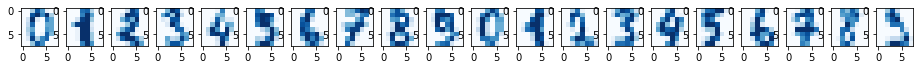

In [417]:
fig, axs = plt.subplots(1, 20)
fig.set_size_inches(16,8)

for i in range(20):
    axs[i].imshow(digit_data[i].reshape(8,8), cmap='Blues')

To visualise the whole dataset we can project the data down to two dimensions. We will use two common methods for this PCA and UMAP.

PCA finds the linear axes in the data (a weighted combination of the 64 dimensions) that maximise the variance; shows most spread. Subsequent principle components are in directions orthogonal to previous components; they show the directions of maximum variance along a separate axis. Typically components are created in terms of the most important first, and for plotting purposes we usually only keep the first two.

A `PCA` model is created in `sklearn`, specifiying the number of components we which to keep. The the model is then fit to the image data, which in this case means to calculate the first two principle components (axes).

In [418]:
pca_model = sklearn.decomposition.PCA(2)
pca_model.fit(digit_data)

PCA(n_components=2)

We run the `.transform()` method on image data. This will convert the 64 input features to just two principle comonents that we can plot.

In [419]:
pca_proj = pca_model.transform(digit_data)
print(pca_proj.shape)

(1797, 2)


If we plot the first two principle components as a scatter, and color points according to digit class, we can see that there is a degree of segregation. However, it is clear that only taking two principle components is not enough to perform a good separation.

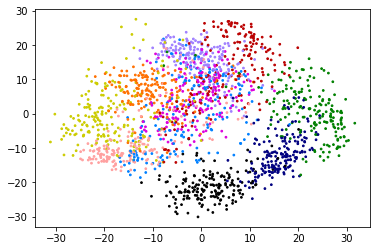

In [420]:
cmap = util.colorlist(*util.DIGIT_COLORS)
               
plt.scatter(*pca_proj.T, s=3, c=digit_labels, cmap=cmap)

UMAP seeks to plot points in a lower dimensional space (fewer axes) to maximise similarity of close points. This is unlike PCA that essentially maximises dissimilarity. An advantage of UMAP, and other similar methods like tSNE, is that it tends to cluster points that are similar (along the range of input features) even if the features don't separate well if globally projected to 2D (e.g. with PCA). It should be noted that the closest points in the input data will be close in the UMAP, but as input points become more dissimilar their precise separation on the UMAP becomes more meaningless.

UMAP is invoked in an analogous manner to PCA. However, it is notable that `UMAP` is *not* provided by `sklearn` and its module must be installed separately. 

In [421]:
from umap import UMAP
umap_model = UMAP(n_components=2)
umap_model.fit(digit_data)
umap_proj = umap_model.transform(digit_data)
print(umap_proj.shape)

(1797, 2)


Plotting the 2D projection generated by UMAP we see it does a superb job at separating the labels. In essence PCA did less well here because the boundaries cannot be described in a linear manner (compare k-Means with k-NN above).
Note that re-running UMAP can sometimes result in the 2D coordinates flipping and rotating; local proximity information is preserved each time but the precise, projected coordinates are arbitrary. 

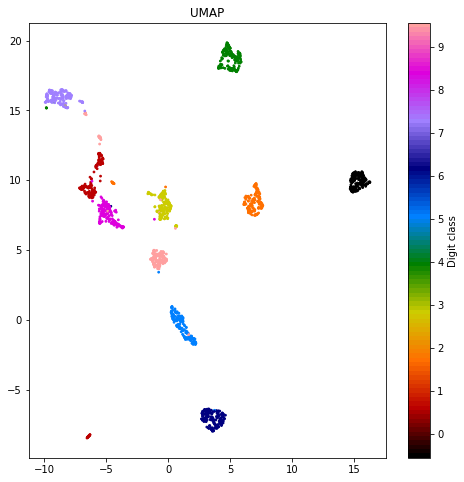

In [422]:
fig, ax = plt.subplots()
fig.set_size_inches(8,8)

sc = ax.scatter(*umap_proj.T, s=3, c=digit_labels, cmap=cmap)
ax.set_title('UMAP')

cb = fig.colorbar(sc, ax=ax)
cb.ax.set_yticks(np.linspace(0.5, 8.5, 10))
cb.ax.set_yticklabels(range(10))
cb.set_label('Digit class')

A different approach to visualising high-dimensional data is to look at a matrix of similarity scores (e.g. distances or correlations) so that we can see an overview of how all data points are related to one another. However, if we do this in a disorganised manner it will almost certainly be difficult to see any patterns, as the rows/columns of our similarity matrix will be in no particular order.

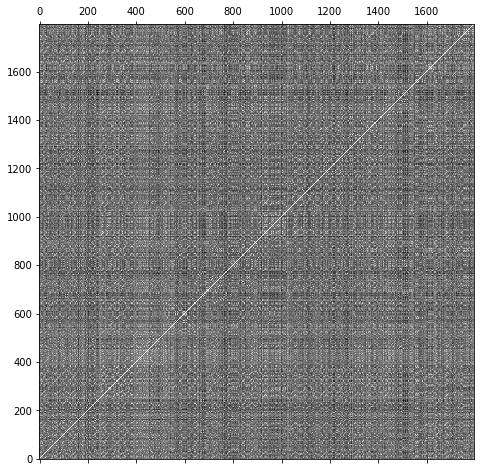

In [424]:
# Plot a correlation matrix of the digit data, in no particular order
from scipy.spatial import distance
dmat = distance.squareform(distance.pdist(digit_data))

fig, ax = plt.subplots()
fig.set_size_inches(8.0, 8.0)
ax.matshow(dmat, origin='lower', cmap='Greys')
plt.show()

So that the similarity of groups within the data become more obvious we need to rearrange the data so that items with similar patterns lie next to one another. In effect this is a dimensionality rediction of points to a one-dimensional order. A conveniant and informative way to group a similarity matrix is to use hierarchical clustering. Accordingly, this constructs a tree of the data points where the outer branch points of the tree join similar data points (the 'leaf' nodes) and the inner branches join similar groups, and groups of groups etc.  

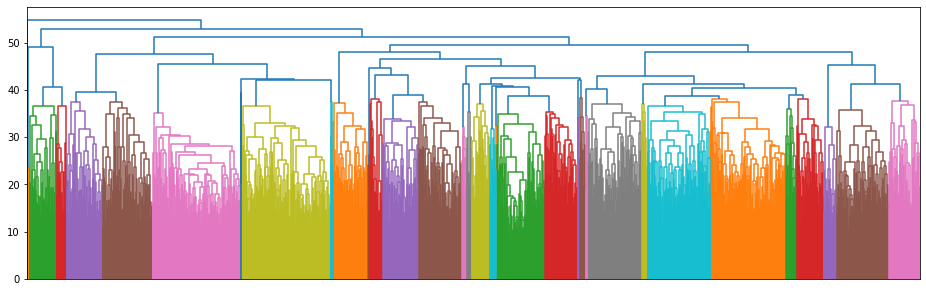

In [427]:
# Reorder correlation matrix according to order from hierarchical clustering
from scipy.cluster import hierarchy
linkage = hierarchy.linkage(digit_data, method='average')      # This is the hierarchical 'tree'

fig, ax = plt.subplots()
fig.set_size_inches(16.0, 5.0)
d = hierarchy.dendrogram(linkage, no_labels=True, ax=ax) # Plot the tree 'linkage' as a dendrogram

While the above dendrogram also shows us that the digit data has structure, it is even more informative to plot the dendrogram along side the distance matrix and to also colour the tree according to the known labels (digit classes 0-9), coloured as before. Configuring these plots can be fiddly, so our `util` module provides a handy `matrix_dendrogram()` function to so this for us.

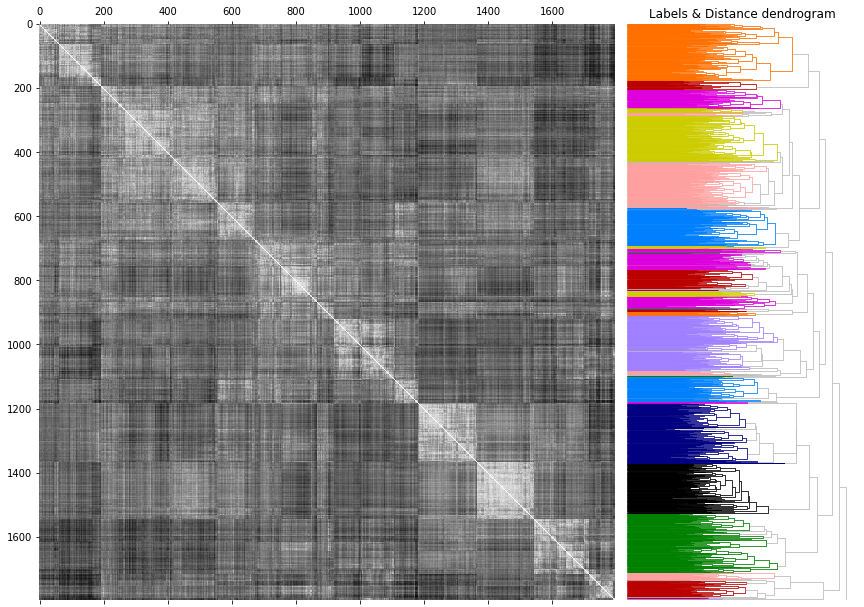

In [43]:
fig = plt.figure()
fig.set_size_inches(16.0, 16.0)

util.matrix_dendrogram(fig, digit_data, digit_labels)

We can see that the hieratchical chustering, at a suitable level of granularity, has largely separated the data into the digit classes, and that this matches what we saw in the UMAP.

##  <font color="purple">Exercise:</font>

<font color="purple">Train an `sklearn` classifier of your choice on the above digit data and compare its predictions to the true/target classes by calculating its accuracy.
</font>

<font color="purple">As time allows, also plot a confusion matric to compare true and preddicted class labels for a test set.
</font>

## Hetrogenous data

The examples of data sets thus far have had homogeneous feature columns; the different features were the same kind of measurement/value, abeit in different positions.

Next we will look at data with hetrogenous features. For this we will use the Wisconsin breast cancer dataset that is provided via `sklearn`. As we can see, there are 569 datapoints with features comprised of different kinds of cytological observation. Each feature will have a different distribution of numerical values, and this we must scale or normalised each of these features separately. 

Below we load the breat cancer dataset and print its description.

In [434]:
bc_set = sklearn.datasets.load_breast_cancer()
print(bc_set.keys())
print(bc_set['DESCR'])

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])
.. _breast_cancer_dataset:

Breast cancer Wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 f

With the data loaded the next task is to split it into test and training sets. As mentioned, we do this prior to any pre-processing so that the test set cannot influence the outcome.

In [435]:
bc_data = bc_set.data
bc_labels = bc_set.target

in_train, in_test, out_train, out_test = sklearn.model_selection.train_test_split(bc_data, bc_labels)

print(in_train.shape, in_test.shape)
print(out_train.shape, out_test.shape)

(426, 30) (143, 30)
(426,) (143,)


To normalise the different feature columns we use the `StandardScaler()`. This will centre each feature on zero (move the mean) and set its standard deviation to 1.0; in essence this is Z-normalisation on the columns.
There are several types of scaler available in `sklearn` but this one works well in this case. In general different scales should be tried and the transformed data plotted to see if it is centred and has a relatively even spread. Often it is a good idea for a feature to be approximately normally distributed, as long as it is centralised and somewhat unbounded. For evenly spread or bounded features (e.g. a coordinate location) it is often sufficient to scale values into a useful range ([0,1] or [-1, +1]).

In [436]:
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(in_train) # Fit to trainaing data only

scaled_in_train = scaler.transform(in_train)
scaled_in_test  = scaler.transform(in_test)
scaled_bc_data = scaler.transform(bc_data)

With the data rescaled we can inspect the distributions of values across the dataset. Firstly we plot histogrms of the original values for each feature, noting the variaty of different value ranges:

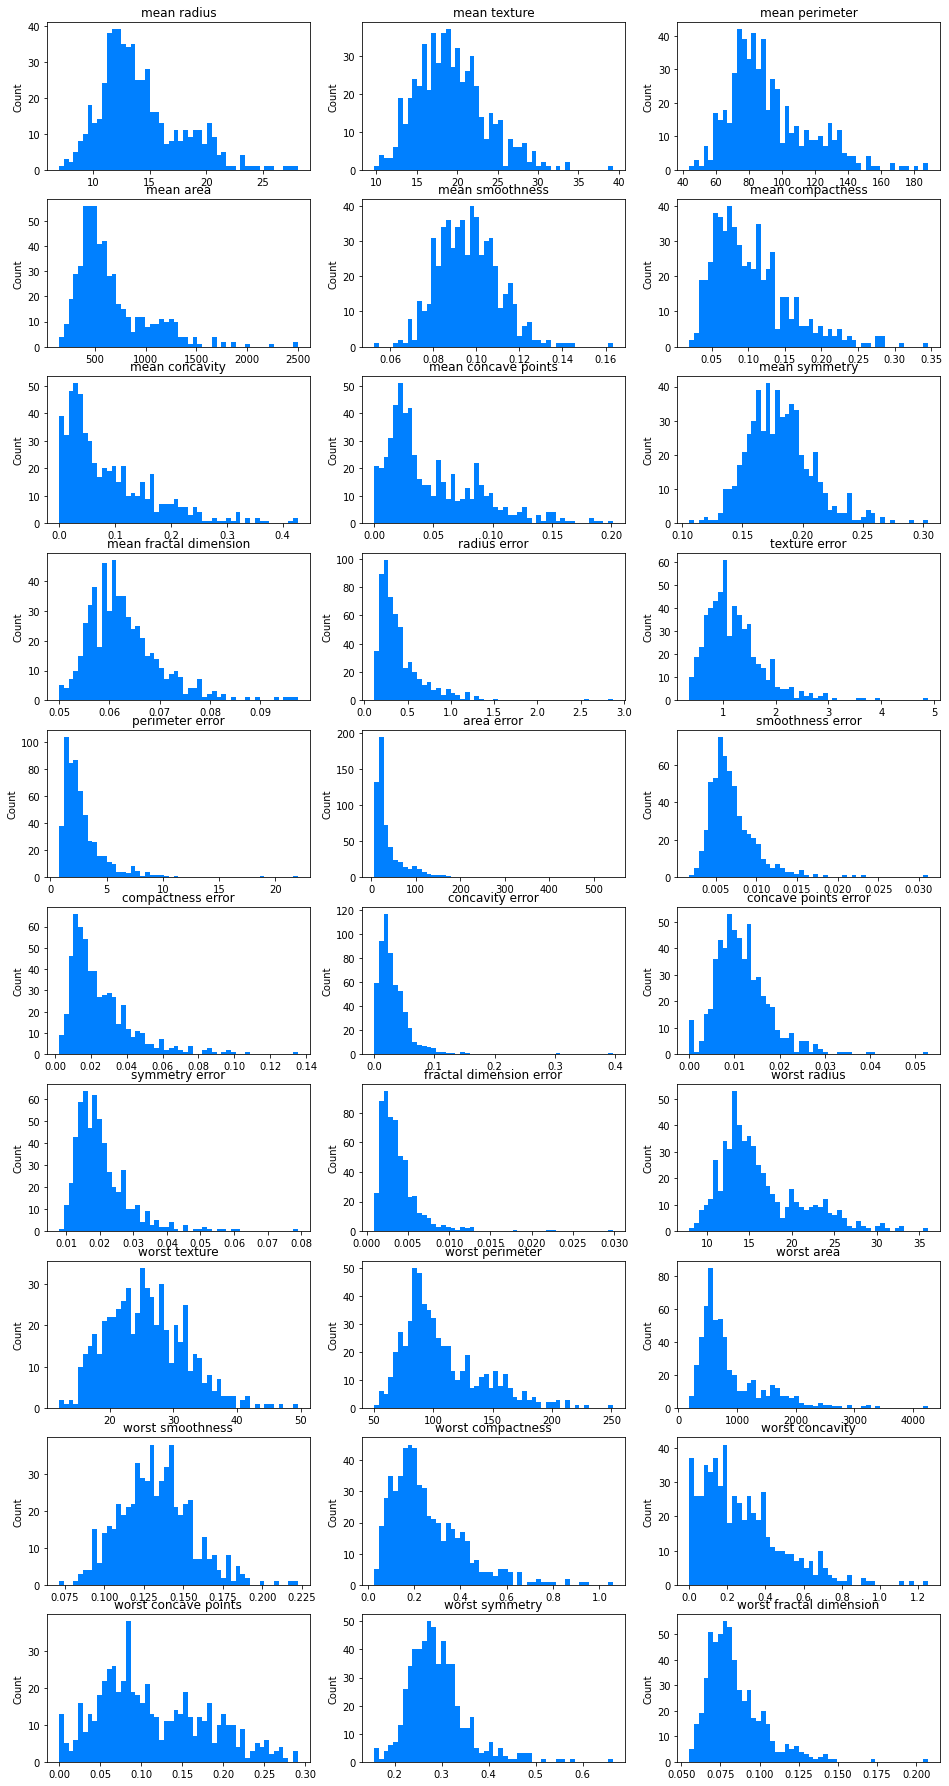

In [437]:
n, m = bc_data.shape
ncols = 3
fig, axs = plt.subplots(10, ncols)
fig.set_size_inches(16,32)

for i in range(m):
    ax = axs[i // ncols, i % ncols]
    ax.hist(bc_data[:,i], bins=50, color='#0080FF')
    ax.set_title(bc_set.feature_names[i])
    ax.set_ylabel('Count')

Next, plotting the scaled data shows each feature has a distribution centred somewhere near 0.0 and with the majority of values within $[-1, 1]$. The overall shape of each feature, however, remains as before.

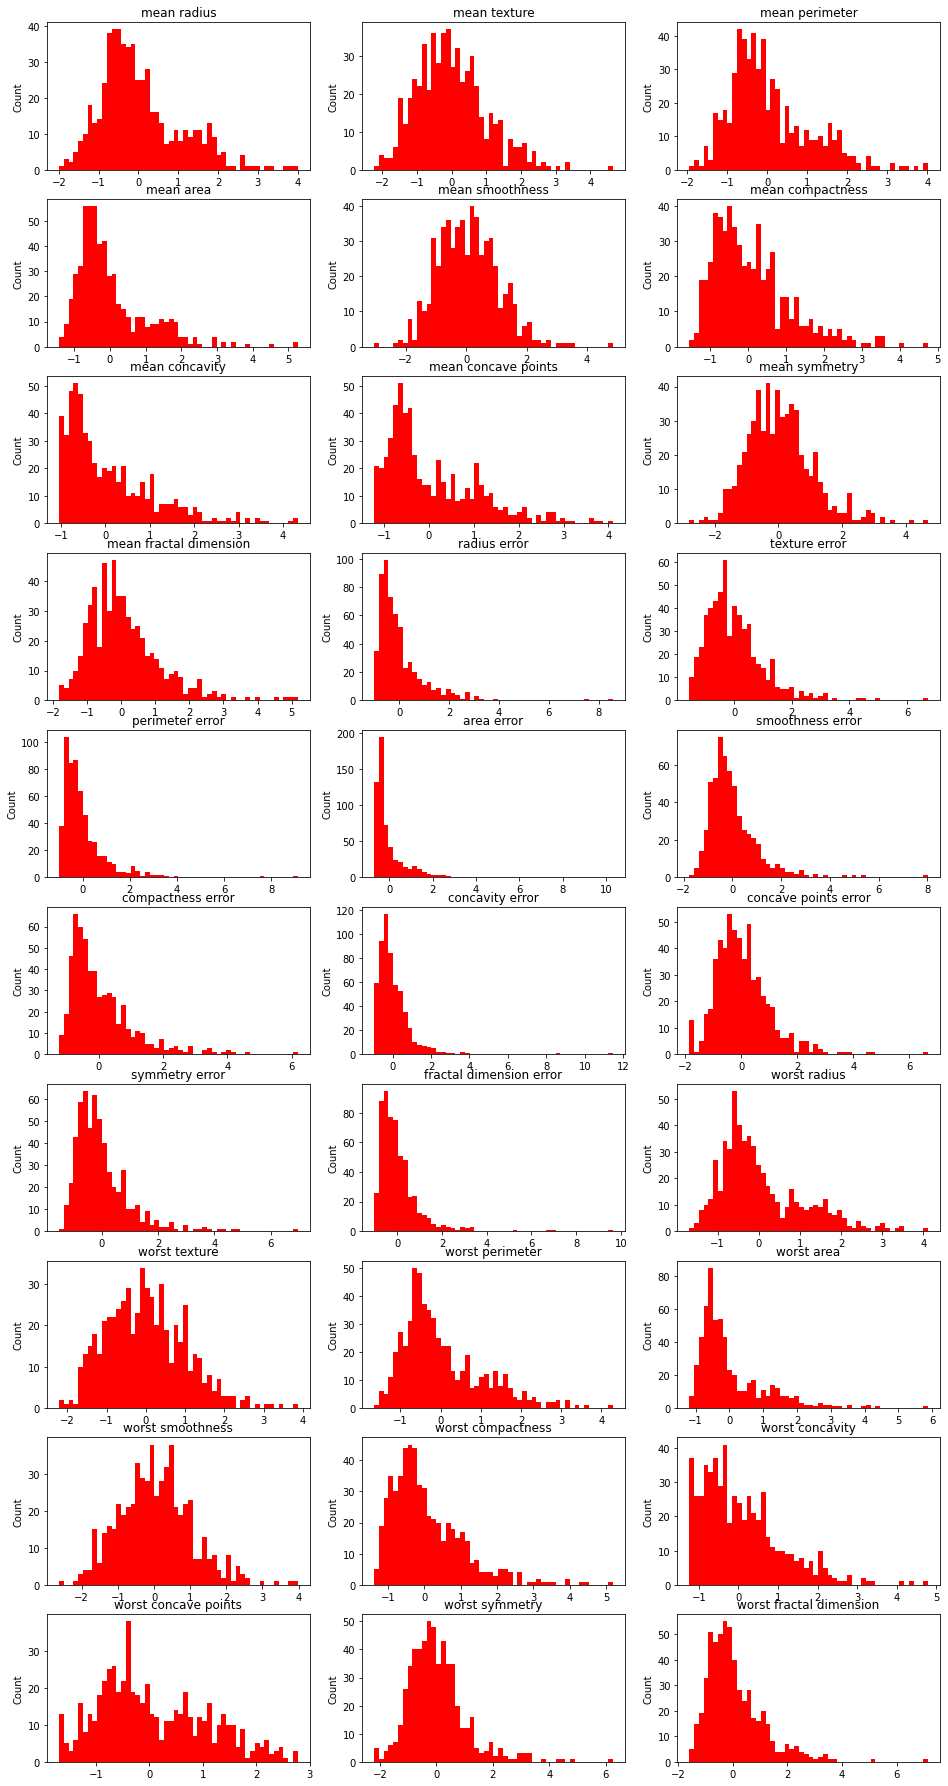

In [438]:
n, m = bc_data.shape

fig, axs = plt.subplots(10, 3)
fig.set_size_inches(16,32)

for i in range(m):
    ax = axs[i // 3, i % 3]
    ax.hist(scaled_bc_data[:,i], bins=50, color='#FF0000')
    ax.set_title(bc_set.feature_names[i])
    ax.set_ylabel('Count')

Next we can plot the data (specifically the training subset in this case), both with and without scaling, to see any internal structure, and how this relates to the two training classes (benign/malignant). Plotting the original, un-normalsed data with class label colours shows that the two classes are largely separate, but the overall structure is snake-like and poorly dispersed. After scaling the data is much better dispersed and the boundary between the two classes is clearer.

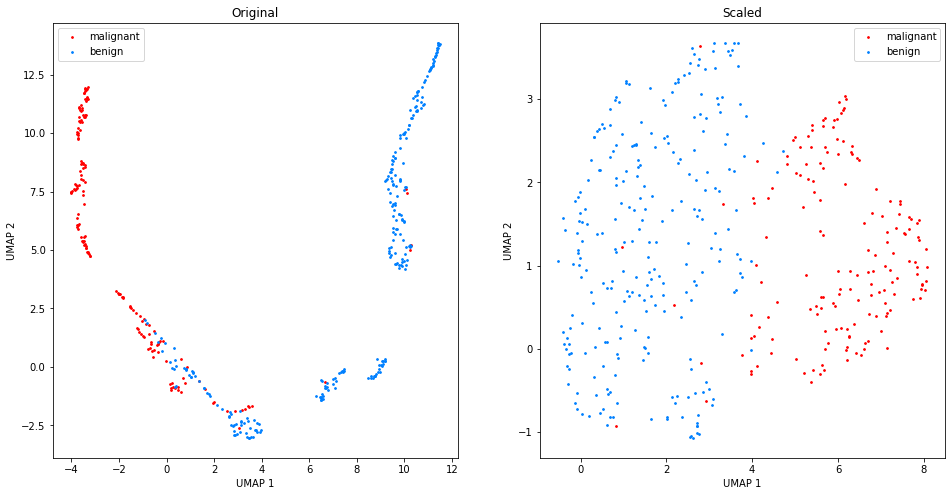

In [221]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,8)
u1 = util.plot_umap(in_train, out_train, bc_set.target_names, ax=ax1, title='Original')
u2 = util.plot_umap(scaled_in_train, out_train, bc_set.target_names, ax=ax2, title='Scaled')

## Class imbalance

When creating classifiers using machine learning models, we should be aware of cases where the number of examples for each class are somewhat different. Often, it can be important to have roughly equal numbers of training examples for each class; otherwise a larger class can dominate a decision boundary with a smaller class. Alternatively, some methods can apply a different weighting to (the members of) each class to address the bias toward the dominant classes. We illustrate class weighting below for an SVM based model, as it is very easily applied using SKlearn.


Next however, we will demonstrate equalising training counts. There are two approaches that are generaly taken: to randomly under-sample a larger class; removing some data to make the set smaller, and to over sample a smaller class; duplicate or interpolate to create new data points. For the Wisconsin dataset we will illustrate a simple under-sampling approach. There are a full range of handy methods for imbalanced class data in the `imbalaced-leartn` module (https://imbalanced-learn.org) that you can also consider.

Here we split the Wisconsin dataset into indices with class label `0` and class label `1` to inslect the class sizes. Note the use of `np.flatnonzero` which gives a 1D array of indices where a particular conditin is true; in this case where the class label is the desired value. As we can see the class sizes are a bit different (though not espcially concerning in this case).

In [440]:
# Fetch array of indices
class0 = np.flatnonzero(bc_labels == 0)  # Where label is first class
class1 = np.flatnonzero(bc_labels == 1)  # Where label is second class
print(f'Malignant: {len(class0)} Benign: {len(class1)}')

Malignant: 212 Benign: 357


We can make the larger of these two classes the same size as the smaller by removing random data points, i.e by **subsampling**. While this means we will be training our machine learning model on less data, it will likely have more general decision boundaries. Also, random subsampling can be done many times to train an ensemble of related models, in a similar manner to the ensemble of classifiers we illustrated above.

To select the subsample the larger class is shuffled and we select the desired number of points from the start of the array:

In [441]:
np.random.shuffle(class1)
class1_subset = class1[:len(class0)]
print(f'Malignant: {len(class0)} Benign: {len(class1_subset)}')

Malignant: 212 Benign: 212


The subsampled selection of indices for the class can then be used to create a complete subsampled dataset, with data poiints, and corresponding labels. From this we can then go on to train a classification model

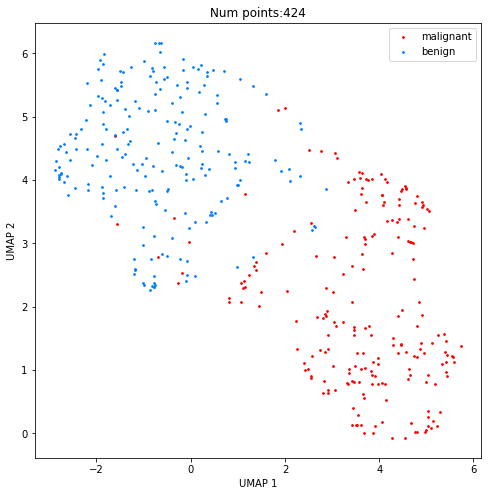

In [442]:
balanced_idx = np.concatenate([class0, class1_subset]) # Join class0 indices and subsampled class 1 indices
balanced_labels = bc_labels[balanced_idx] # Subsample labels
balanced_data = scaled_bc_data[balanced_idx] # Subsample datapoints
umap_model = util.plot_umap(balanced_data, balanced_labels, bc_set.target_names,
                            title=f'Num points:{len(balanced_data)}')

### Class weighted SVM 

To illustrate weighting the members of each class we will use the SVN classifier model `SVC` from `sklearn`. All we have to do is remeber to pass `'balanced'` to the `class_weight` option when we create the model:

In [443]:
svm_model4 = sklearn.svm.SVC(class_weight='balanced')
svm_model4.fit(scaled_in_train, out_train)

svm_classes4 = svm_model4.predict(scaled_in_train)
svm_pred = svm_model4.predict(scaled_in_test)

We can then plot the result, comparing this to the ideal training classes.

As we didi before for the synthetic datam, we can illustrate the (dis)agreement between the 


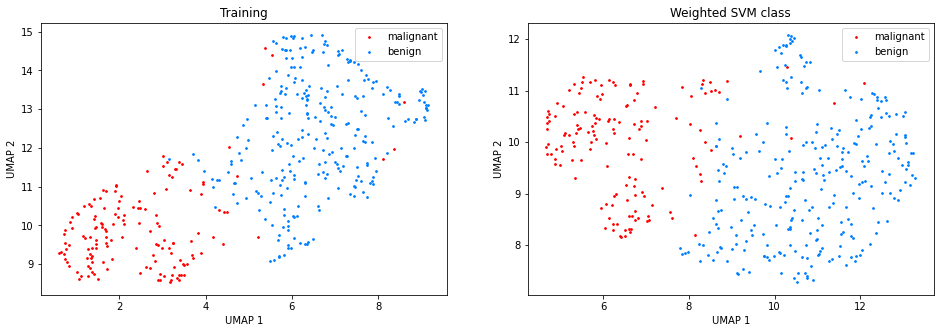

In [444]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,5)
umdl = util.plot_umap(scaled_in_train, out_train, bc_set.target_names, ax=ax1, title='Training')
util.plot_umap(scaled_in_train, svm_classes4, bc_set.target_names, ax=ax2,
               prev_model=umdl, title='Weighted SVM class')

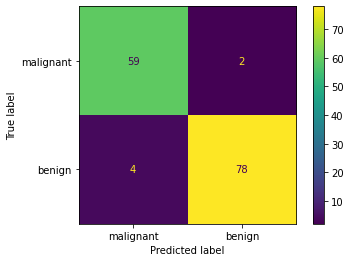

In [445]:
conf_mat = sklearn.metrics.confusion_matrix(out_test, svm_pred)
disp = sklearn.metrics.ConfusionMatrixDisplay(conf_mat, display_labels=bc_set.target_names)
disp.plot()
plt.show()

##  <font color="purple">Exercise:</font>

<font color="purple">Train an SVM classifier without using class weighting and create a corresponding confustion matrix to compare its predictions to the class-weighted SVM.
</font>

## Feature importance
 
Given a trained model, we can begin to asses which of the features ('columns') within the data are most important for its predictive power. There are various methods to do this and here we demonstrate *permutation importance*. In essence what this does is to take each feature column in turn, separately suffle the data for the feature (permute among rows) and measure the impact of the shuffling on the prediction. Those features where shuffling makes little difference are deemed unimportant, and those for which predictions are worsened are mo

Here we use `permutation_importance()` and look at the average importance scores, over a number of repeats, for the Wisconsin breast cancer dataset. As, can be seen the "worst texture" and "mean texture" features seem to be the most important. 

In [238]:
from sklearn.inspection import permutation_importance
result = permutation_importance(svm_model4, scaled_in_test, out_test, n_repeats=20, random_state=7)
importance = result.importances_mean
order = importance.argsort()[::-1]

print(f'FEATURE                    IMPORTANCE')
for i in order:
    print(f"{bc_set.feature_names[i]:24} {importance[i]:9.4f}")

FEATURE                    IMPORTANCE
worst symmetry              0.0164
worst texture               0.0154
radius error                0.0136
worst smoothness            0.0126
mean texture                0.0115
mean fractal dimension      0.0108
worst area                  0.0101
compactness error           0.0091
worst fractal dimension     0.0084
smoothness error            0.0080
worst perimeter             0.0080
worst radius                0.0077
perimeter error             0.0073
mean area                   0.0073
mean concavity              0.0070
worst concave points        0.0066
mean radius                 0.0066
concavity error             0.0063
mean perimeter              0.0063
worst concavity             0.0056
mean concave points         0.0056
symmetry error              0.0056
texture error               0.0045
concave points error        0.0045
area error                  0.0042
mean compactness            0.0038
mean symmetry               0.0038
fractal dimension

## Missing values

So far we have not discussed situations where there is missing data. In part, this is because all of the handy example data used so far has nothing missing. Nonetheless, missing data is fairly common in certain sitiations, e.g. for single cell RNA-seq, shotgun proteomics etc, and can be thought of as a kind of noise.
 
By "missing values" we mean where there is no data for a particular element of a data array, this is dictinct from a value of zero. Genrally missing values will be represented by a placeholder such as "nan" (not a number), "none" or "." etc. A few methods can handle missing values, e.g. decision trees and random forest can operate with what is available. Most, however, cannot and require a number to be substituted for the placeholder, if we are to make progress. A crude approach would be remove the rows and or columns with missing values; this naturally removes data that may be helpful, and is generally unnecessary. 

Sometimes a missing value can be substituted with a sensible number, such as zero or a mean feature value, but this is only appropriate in some situations, for some features. Mean values are sometimes used to insert a non-special number for a feature. This can be appropriate is data is lost completely at random (e.g. a glitching sensor etc), though there are better methods. Zeros, (or almost zeros) can be useful repacement if the reason for missing data is generally a sensitivity problem; missing because it dropped off the lower end of the value scale. Missing data here is **not random**. Using a mean value for this is inappropriate, because a mean value is far from the unseen truth which is at or near zero.

Generally a good approach to deal with missing values is to use a dedicated imputation toot, and helpfully `sklearn` provides a few of these to use (https://scikit-learn.org/stable/modules/impute.html). A common method is find k-nearest neighbours (calculated with the actuallyvalues present) and then use the neighbouring points to cenerate a local average to substitute for the missing values. This approach is appropriate for elements that are missing randomly, but correlates somehow with the data. 

By randomly removing half of the values from the Wisconsin datset, we demonstrate use of nearest-neighbour imputation.

In [446]:
make_null = np.random.uniform(0.0, 1.0, scaled_in_train.shape) < 0.5   # Random mask 
missing_in_train = np.array(scaled_in_train)
missing_in_train[make_null] = np.nan # Remove random half the data

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5, weights="uniform")
imputed_in_train = imputer.fit_transform(missing_in_train)

As can be seen, the imputation reconstructs much of the shape and original separation of the two classes in the 2D projection.

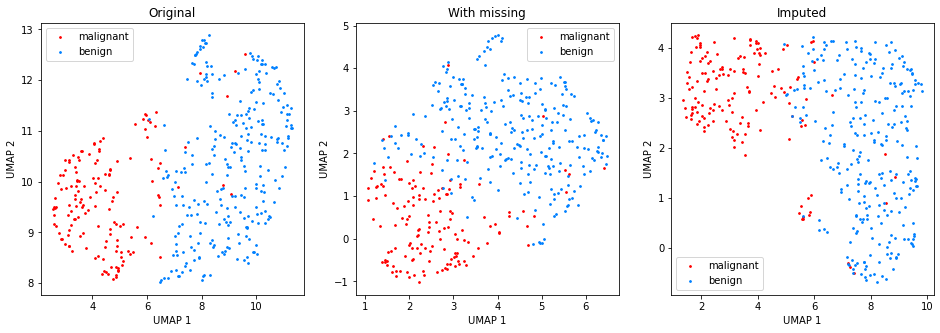

In [447]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_size_inches(16,5)
mdl = util.plot_umap(scaled_in_train, out_train, bc_set.target_names, ax=ax1, title='Original')
util.plot_umap(np.nan_to_num(missing_in_train), out_train, bc_set.target_names, prev_model=mdl, ax=ax2, title='With missing')
util.plot_umap(imputed_in_train, out_train, bc_set.target_names, prev_model=mdl, ax=ax3, title='Imputed')

## Regression

In the examples we have used so far the objective for our prediction has been categorical, i.e. selection from from among a discrete number of options. However, may problems involve modelling predictions for continuous values. Broadly this is referred to as "regression". To illustrate the construction of regressive models we will use another `sklearn` dataset, this time relating to the sale price of houses in California. 

In [448]:
housing_data = sklearn.datasets.fetch_california_housing()

The `housing_data` is a Python dictionary where we can use the keys to access the input (`'data'`), and the corresponding names for the features found in the columns.

In [449]:
print(housing_data.keys())
print(housing_data['data'].shape)
print(housing_data['feature_names'])

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])
(20640, 8)
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


The output (`'target'`) relates to the median house value for a geographic area, which is continuous tough has been bounded at the upper end of the scale.

Num "MedHouseVal" values: 20640


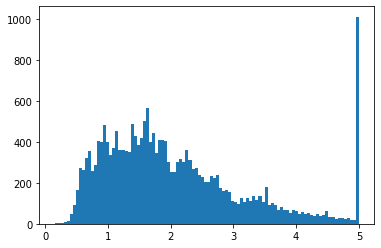

In [459]:
n = len(housing_data['target'])
tname = housing_data['target_names'][0]
print(f'Num "{tname}" values: {n}')

plt.hist(housing_data['target'], bins=100)
plt.show()

## Data preprocessing, normalisation

As we did with the Wisconsin dataset we need to pre-process the hetrogenous features of the data prior to training models etc. In this case, however, rather than using the Z-normalisation (provided by the `StandardScaler`) we will use `PowerTransformer()`. The reason for this is that the input features are zero-bounded and have a large dynamic range.

The transformation finds a power value, such that the data raised to this power is distributed more normalley (closer to Gaussian) and then centers the value on 0.0 and scales to mainly be in $[-1, 1]$

In [460]:
train_data = housing_data['data']
house_vals = housing_data['target']
scaler = sklearn.preprocessing.PowerTransformer()
scaler.fit(train_data)
scaled_data = scaler.transform(train_data)

Plotting the input values, per feature, before and after the preprocessing illustrates how this works.

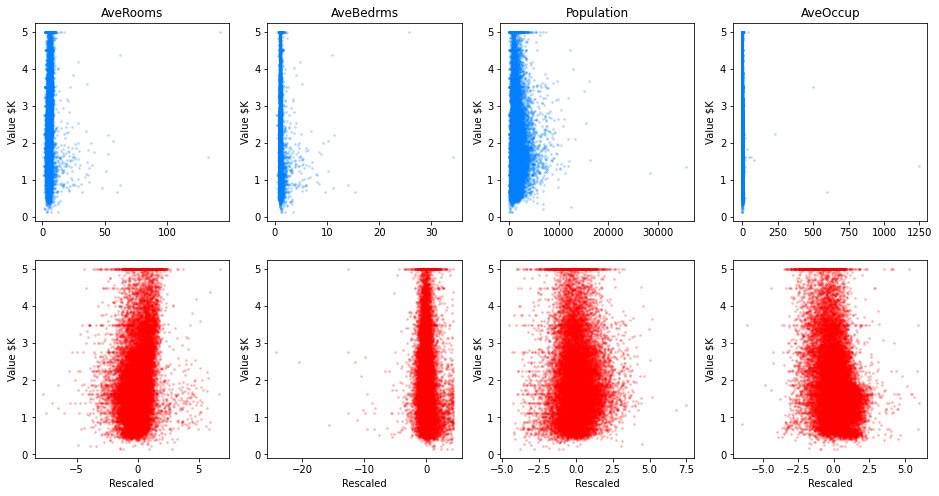

In [461]:
fig, axs = plt.subplots(2, 4)
fig.set_size_inches(16,8)

for i in [2,3,4,5]:
    ax1 = axs[0, i-2]
    ax1.scatter(train_data[:,i], house_vals, color='#0080FF', s=3, alpha=0.2)
    ax1.set_title(housing_data['feature_names'][i])
    ax1.set_ylabel('Value $K')
    
    ax2 = axs[1, i-2]
    ax2.scatter(scaled_data[:,i], house_vals, color='#FF0000', s=3, alpha=0.2)
    ax2.set_ylabel('Value $K')
    ax2.set_xlabel('Rescaled')

These data will be used in subsequent ML models. Here we plot the scaled data as 2D PCA and UMAP, colouring by Dollar value. The data shows some organisation with regards to clustering the most and least expensive areas, though the relationship in these projections is far from straightforward.

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

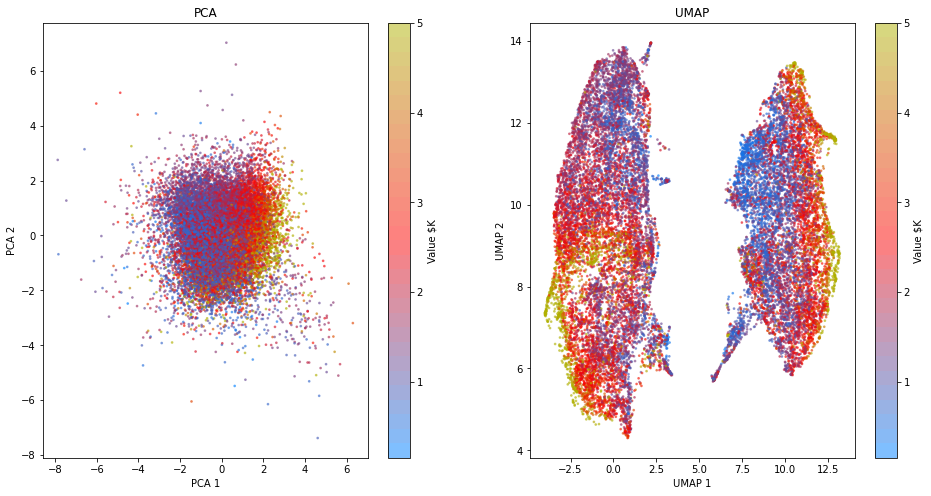

In [462]:
import course_util as util
import importlib
importlib.reload(util)

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,8)

util.plot_proj2d(scaled_data, house_vals, 'Value $K', ax=ax1, method=sklearn.decomposition.PCA, cmap=cmap1)
util.plot_proj2d(scaled_data, house_vals, 'Value $K', ax=ax2, method=UMAP, cmap=cmap1)

Given that the dollar values don't have a huge dynamic range we can apply a standard Z-normalisation. Using the `PowerTransformer` here is also fine, though more fiddly.

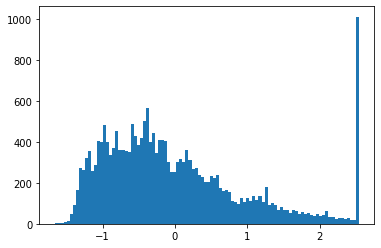

In [463]:
scaled_vals = (house_vals - house_vals.mean())/house_vals.std()
p1 = plt.hist(scaled_vals, bins=100)

Next we will create an SVR model; a regression variant of a support vector machine. This is trained in the scaled data to approximate the scaled data. Note that for brevity we only show the basic process, and skip test-train splits etc.

In [464]:
svr_model = sklearn.svm.SVR()
svr_model.fit(scaled_data, scaled_vals)
predicted_vals = svr_model.predict(scaled_data)

Plotting the ideal price data and the predicted values we can see the correspondence bewteen the two. It is notable that the clipping of the high cost end has generated an artefact.

Correlation: 0.866


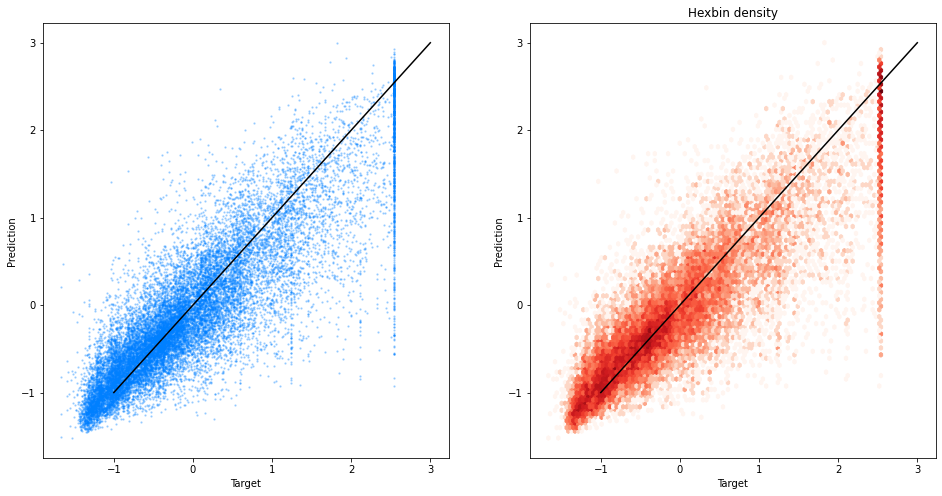

In [479]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16,8)

ax1.scatter(scaled_vals, predicted_vals, s=2, color='#0080FF', alpha=0.25)
ax1.plot([-1, 3], [-1, 3], color='k') # Ideal, diagonal line
ax1.set_xlabel('Target')
ax1.set_ylabel('Prediction')

ax2.hexbin(scaled_vals, predicted_vals, bins='log', cmap='Reds')
ax2.set_title('Hexbin density')
ax2.plot([-1, 3], [-1, 3], color='k') # Ideal, diagonal line
ax2.set_xlabel('Target')
ax2.set_ylabel('Prediction')

corr = np.corrcoef(scaled_vals, predicted_vals)[0,1]
print(f'Correlation: {corr:.3f}')

A 2D projection of the data coloured by predicted and ideal price shows that the range of predictions has the same overall structure, but that there are many differences at a small scale. The predicted data seems to have learned a smooth model, where there are gradients of price, whereas the real data appears somewhat more spiky. Having stochastically variable, noisy real data is to be expected.

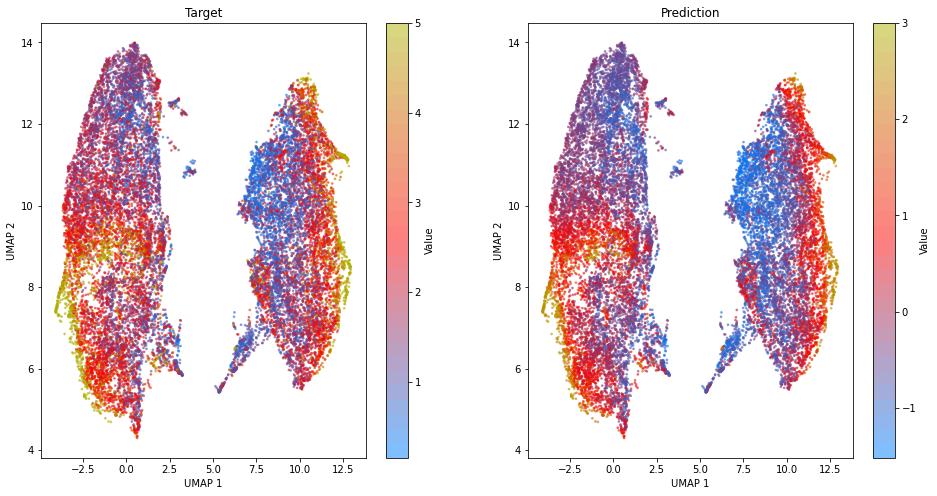

In [480]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,8)

ump = util.plot_proj2d(scaled_data, house_vals, 'Value', title='Target', ax=ax1, cmap=cmap1)
util.plot_proj2d(scaled_data, predicted_vals, 'Value', title='Prediction', ax=ax2, cmap=cmap1, prev_model=ump)

# Sequence data

Finally, we take a brief look at some biological sequence data (there are further sequence examples in the neural network course). Specifically, this will be protein amino acid sequences that are stored as one-letter codes.

Some demonstration data is provided with this course form the `util` module. With the data loaded we can see that it is arranged as a list of lists. Each inner list represents a data row and contains a sequence of characters representing the one-letter codes. 

In [481]:
seqs = util.load_sequences()
print(seqs[0])

['G', 'K', 'K', 'R', 'S', 'T', 'A', 'L', 'F', 'V', 'F', 'C', 'G', 'A', 'L', 'V', 'I', 'V', 'T', 'V', 'F', 'A', 'V', 'T', 'Y', 'A', 'A', 'R', 'I', 'I', 'T', 'I', 'S', 'H', 'K', 'S', 'P', 'P', 'P', 'D']


To use this categorical data with most machine learning methods we need to encode the different amino acid classes numerically. Typically this is done using what is termed *one-hot encoding*. The idea here is that each position in the sequence is represented by a vector of length 20 (because there are 20 possible amino acid types) where one value, representaing the type of amino acid present, is set to `1.0` and all other values are set to `0.0`. In other words the **position** of the `1.0` in the array of 20 indicates the amino acid class.

The `sklearn` module provides a handy method to convert our initial list of one-letter labels into a one-hot vector. The `categories` available for each column is the same list of possible amino acid sequences. There are `5000` protein sequences in the example data, so that is the number of output rows. The number of feature columns is `800` because we have 40 positions of 20 possibilites, noting that the encoder has joined the one-hot encodings for each protein sequence position into one long vector. It is notable here that we must specifiy the categories (from a list of acceptable amino acid codes). This is required because the `OneHotEncoder` would otherwide be frugal, and would not necessarily use the same encoding for each sequence position; if an amino acid type were entirely missing in from a position (over the whole dataset) it would be omitted from the encoding. Position dependent encoding may be unhepful with such homogenous (in this case all amino acid) data, as it doesn't allow the data to be offset or used with position independent methods (such as convolutional neural networks).

In [482]:
aas = list('ACDEFGHIKLMNPQRSTVWY')
cats = [aas for i in range(len(seqs[0]))]
encoder = sklearn.preprocessing.OneHotEncoder(sparse_output=False, categories=cats)
seq_data = encoder.fit_transform(seqs)
print(seq_data.shape)

(5000, 800)


If we inspect the `seq_data` we find that each row is indeed mostly zeros, with a `1.0` within every 20 values.

In [483]:
print(seq_data[0,:20])   # Row 0, first sequence pos
print(seq_data[0,20:40]) # Row 0, second sequence pos

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Doing a PCA transform of this data shows that the sequence data has some interesting structure.

(5000, 2)


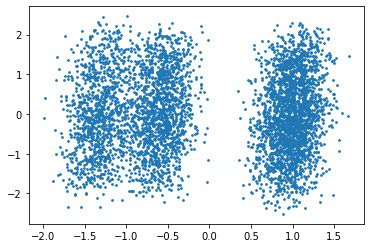

In [431]:
pca_model = sklearn.decomposition.PCA(n_components=2, whiten=True)
pca_proj = pca_model.fit_transform(seq_data)
print(pca_proj.shape)

plt.scatter(*pca_proj.T, s=3)

Performing PCA on the sequence data but keeping more than two compomponents allows us to create a lower dimensionality approximation to the data. Here we investigate this compressed representation for structure using UMAP.

(5000, 20)
(5000, 2)


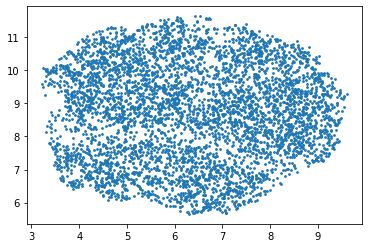

In [488]:
pca_big = sklearn.decomposition.PCA(n_components=20, whiten=True)
pca_big_proj = pca_big.fit_transform(seq_data)

umap_seq_proj = UMAP(n_components=2).fit_transform(pca_big_proj)
print(pca_big_proj.shape)
print(umap_seq_proj.shape)

plt.scatter(*umap_seq_proj.T, s=3)
plt.show()

## Hyperparameter opimisation

In aspect of machine learning that we will not go into in detail is hyperparameter optimisation. For example, what is the best value for $k$ in a k-nearest neighbour classifier? This is a form of high-level optimisation, and getting  these parameters correct can make a big difference. However, usually we try to make a classifier or regressor work in s sensible manner, with appropriate data normalisation etc. and then only optimise hyperparameters when we know we're on the right track.

It is often easy to try various parameters, and even different machine learning methods, with a helpful library like `sklearn`. We can then use objective metrics of performace, as described, to asses our models and parameters. However, hyperparameter searches can be automated, which is ideal for models that are quick to train; high-level optimisations have to perform many training/fitting runs. A good place to start with such automation is `auto-sklearn`, which build upon the kinds of models we have looked thourgh here:

https://automl.github.io/auto-sklearn/master/

This tests ensembles of different classifiers with Bayesian optimisation..
  